In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
import theano

In [2]:
elements = pd.read_csv('pd_data/elements_men.csv')
components = pd.read_csv('pd_data/components_summary_men.csv')
elements.date = elements.date.astype('datetime64')
components.date = components.date.astype('datetime64')

In [3]:
skaters = sorted(elements.skater.unique())
num_skaters = len(skaters)
skater_lookup = dict(zip(skaters, xrange(len(skaters))))

In [49]:
skater_start = {}
for skater in elements.skater.unique():
    skater_elts = elements[elements.skater == skater]
    skater_start[skater] = skater_elts.date.unique()[0]

In [11]:
elements['weeks_since_skater_start'] = elements.apply(lambda row: row.date - skater_start[row.skater], axis=1).astype('timedelta64[W]')
components['weeks_since_skater_start'] = components.apply(lambda row: row.date - skater_start[row.skater], axis=1).astype('timedelta64[W]')

In [12]:
overall_start = elements.date.unique()[0]
elements['weeks_since_overall_start'] = elements.apply(lambda row: row.date - overall_start, axis=1).astype('timedelta64[W]')
components['weeks_since_overall_start'] = components.apply(lambda row: row.date - overall_start, axis=1).astype('timedelta64[W]')

In [7]:
ELT_TYPES = ('ch', 'st', 'sp', '1j', '2j', '3j', '4j')
COMP_TYPES = ('ss', 'tr', 'pe', 'co', 'in')

In [8]:
results = {}  # dict of (trace, model, theano shared)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [04:49<00:00,  5.18it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.988852948968, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



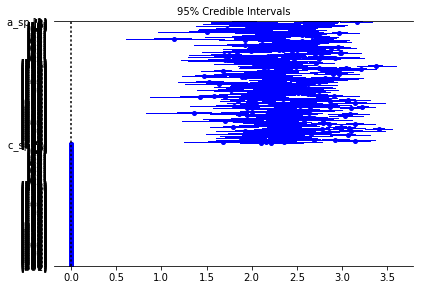

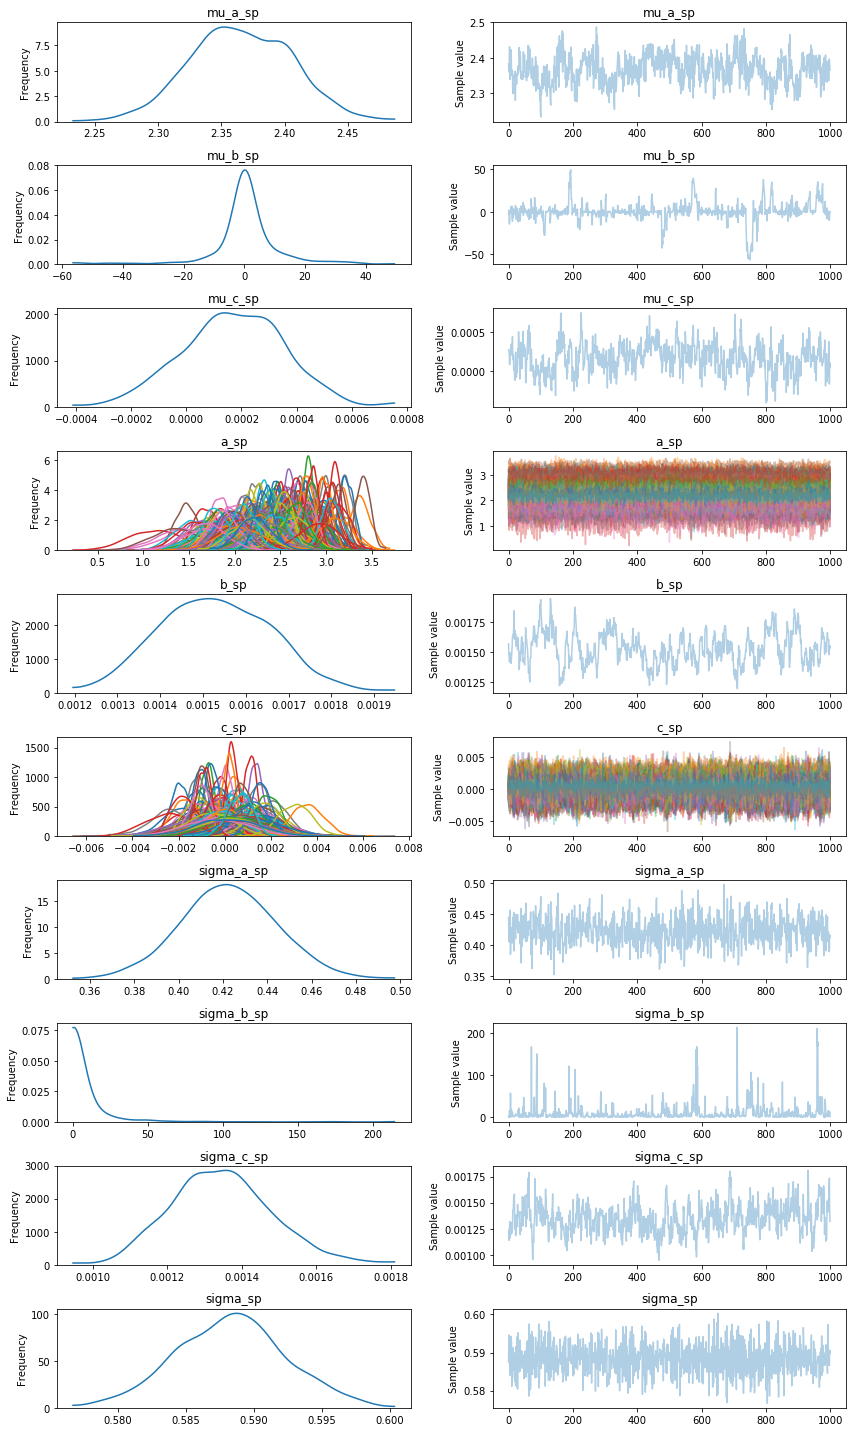

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1499/1500 [02:11<00:00, 11.44it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.971478294301, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1500/1500 [02:11<00:00, 11.45it/s]


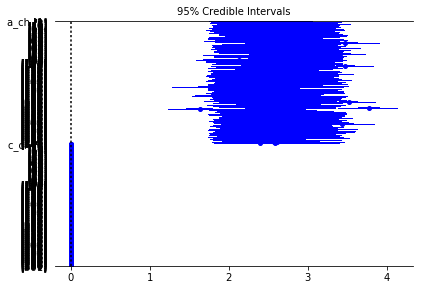

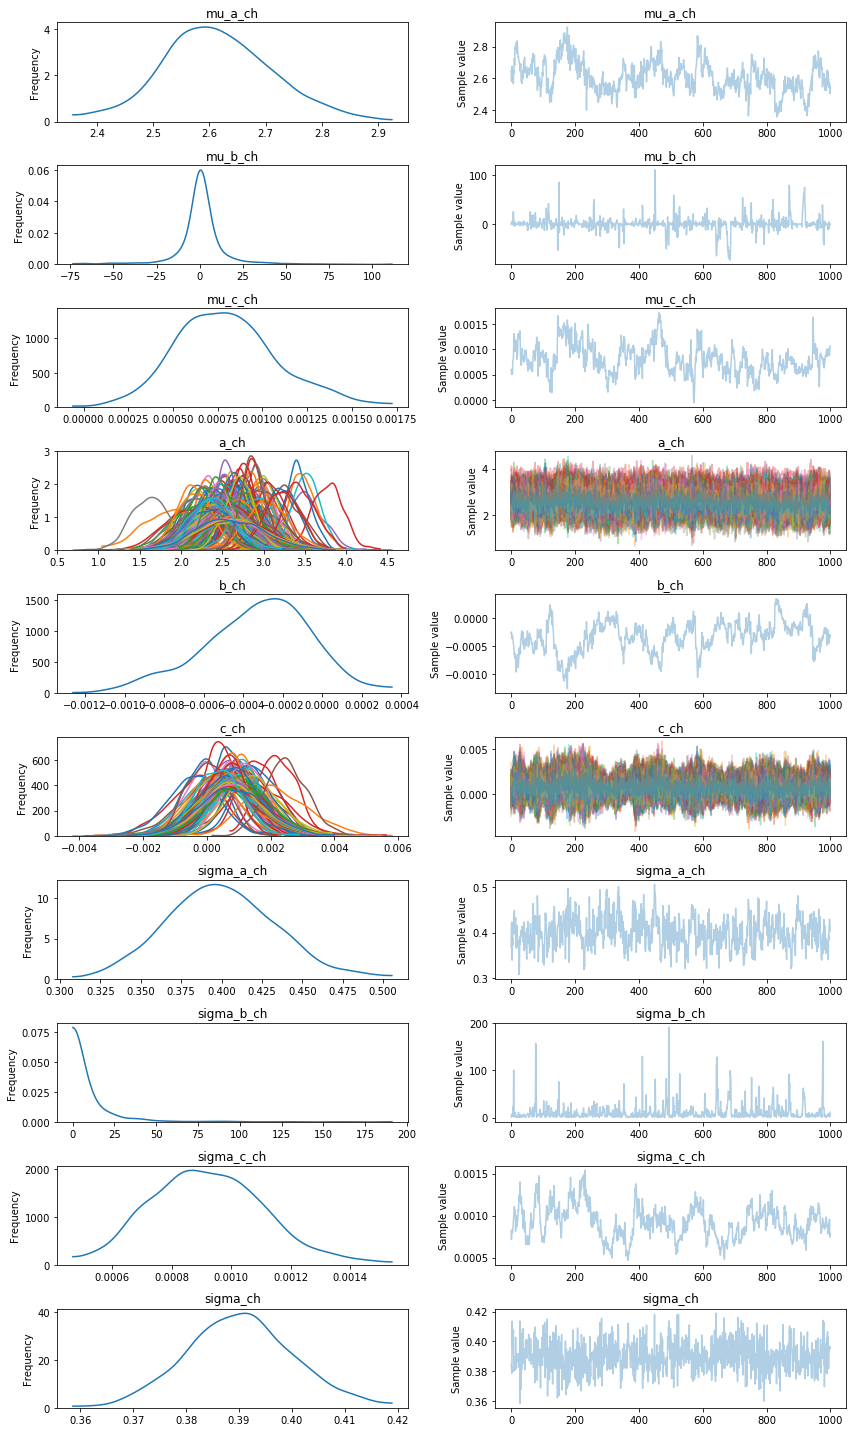

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [03:12<00:00,  7.80it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.973550780689, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 28 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



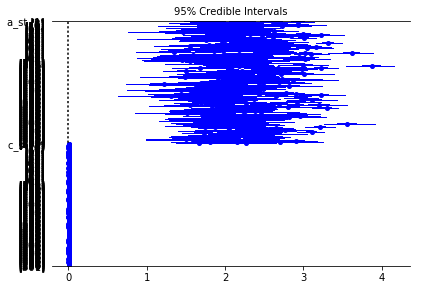

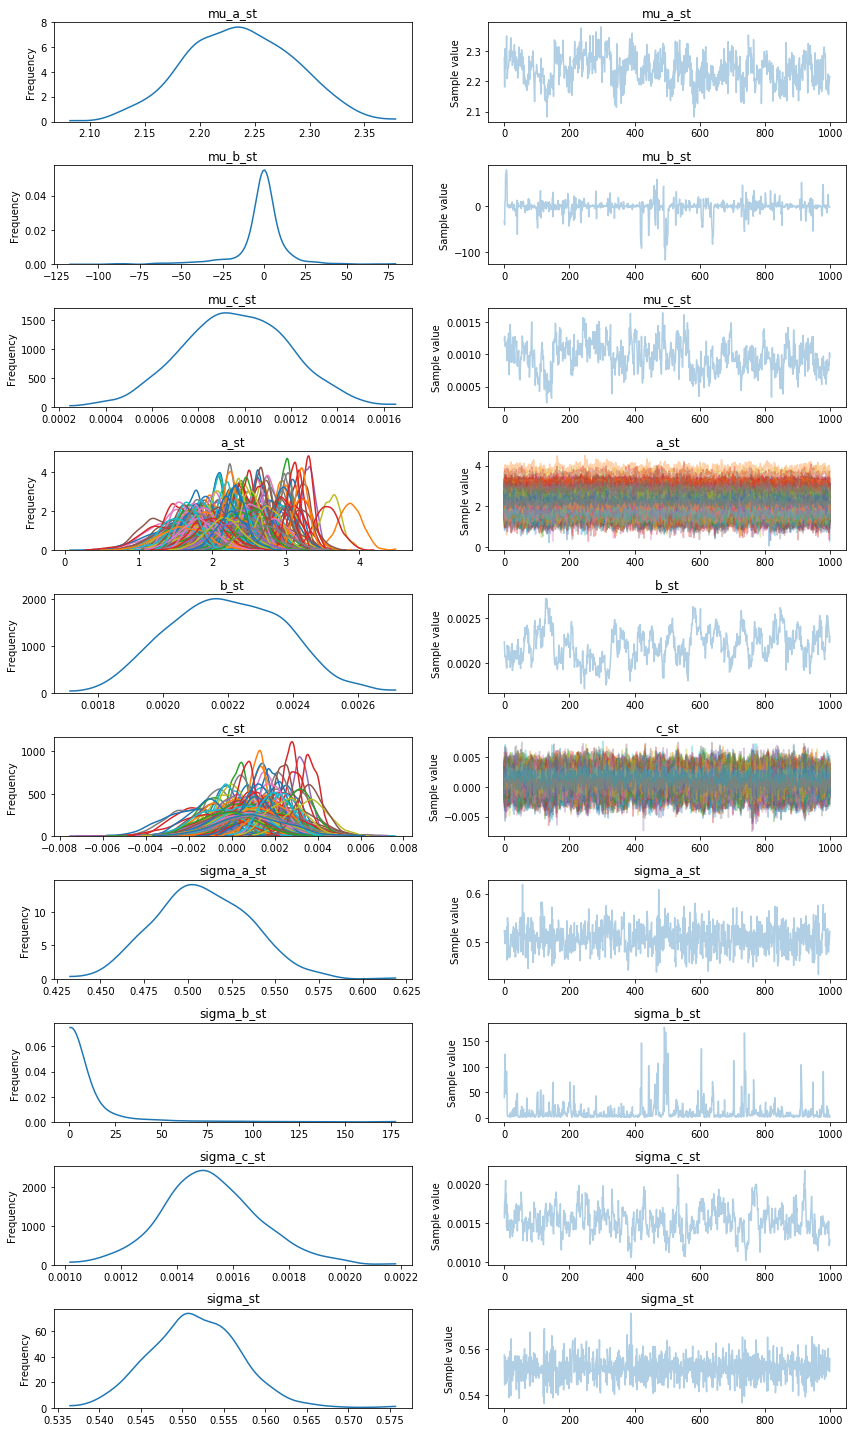

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [02:04<00:00, 12.05it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.977947544004, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



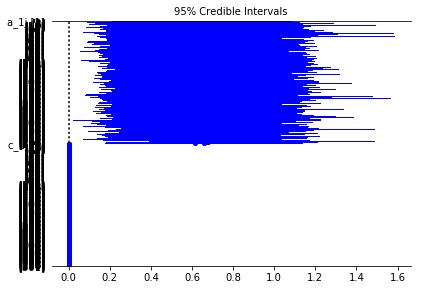

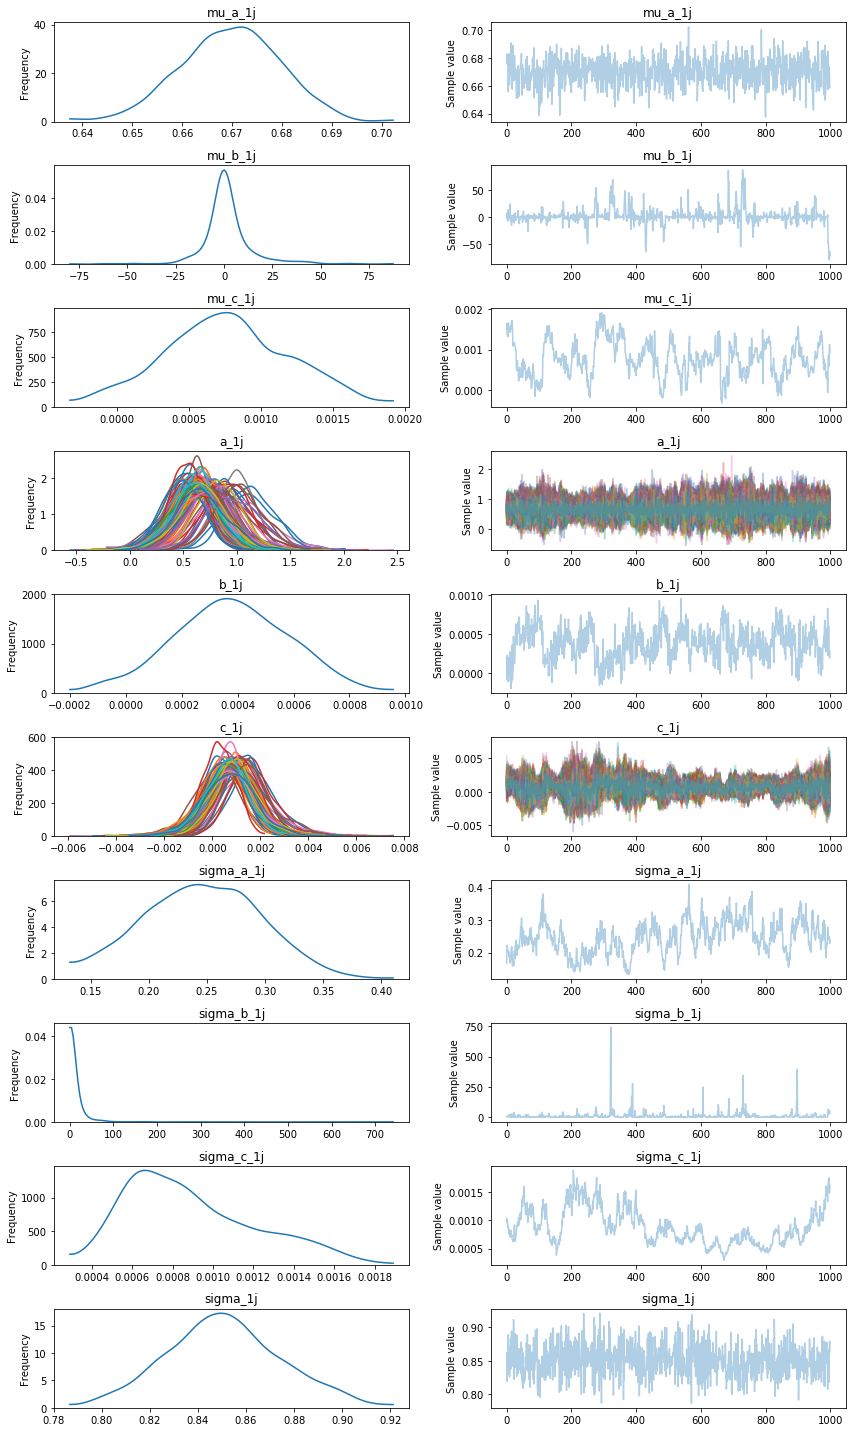

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [01:54<00:00, 13.10it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.932773895558, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 41 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



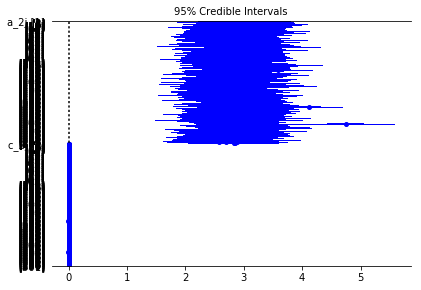

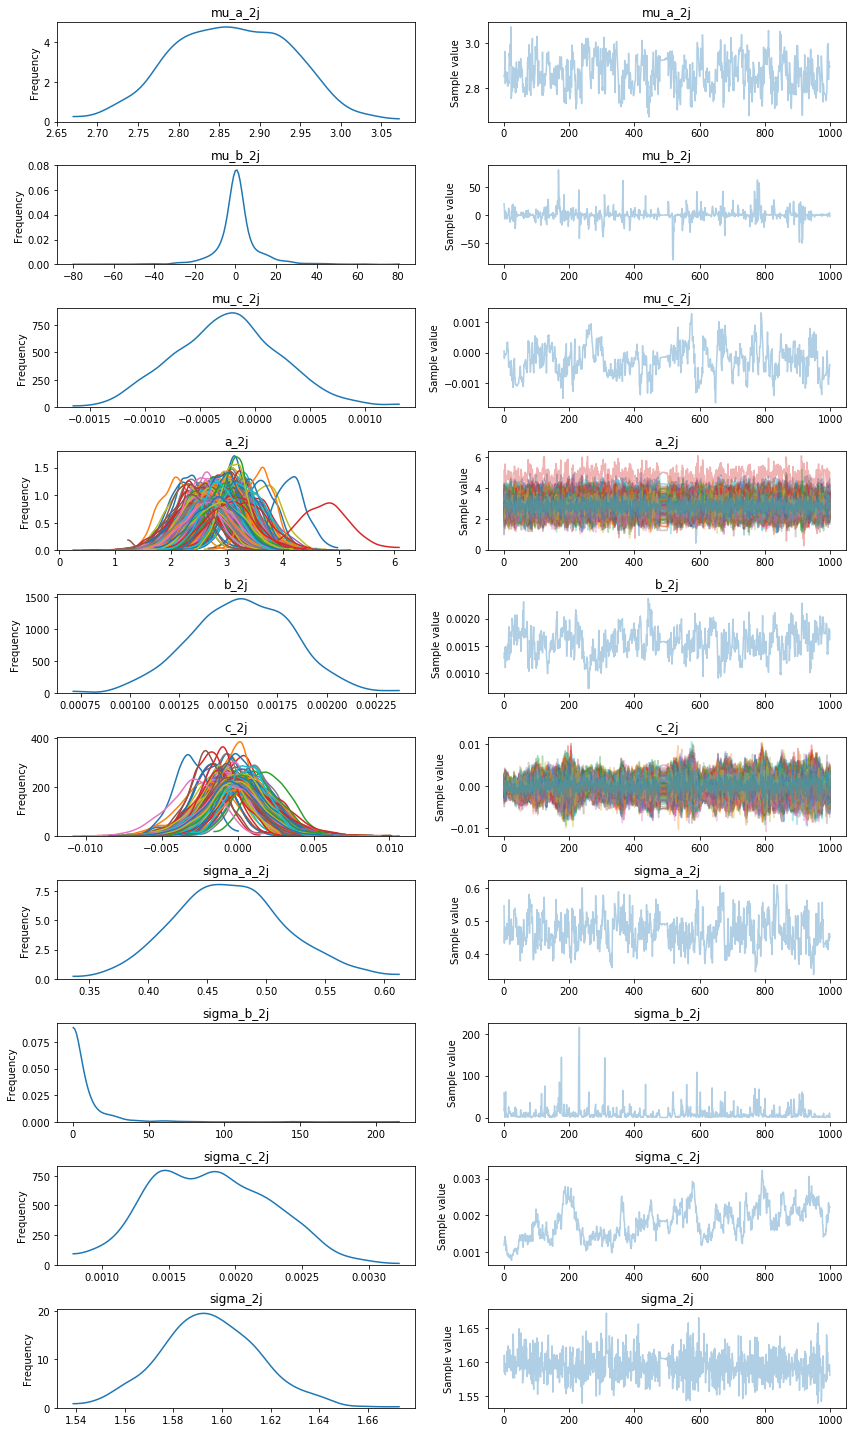

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [07:42<00:00,  3.24it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.971331656046, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



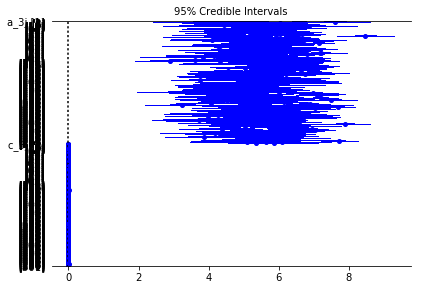

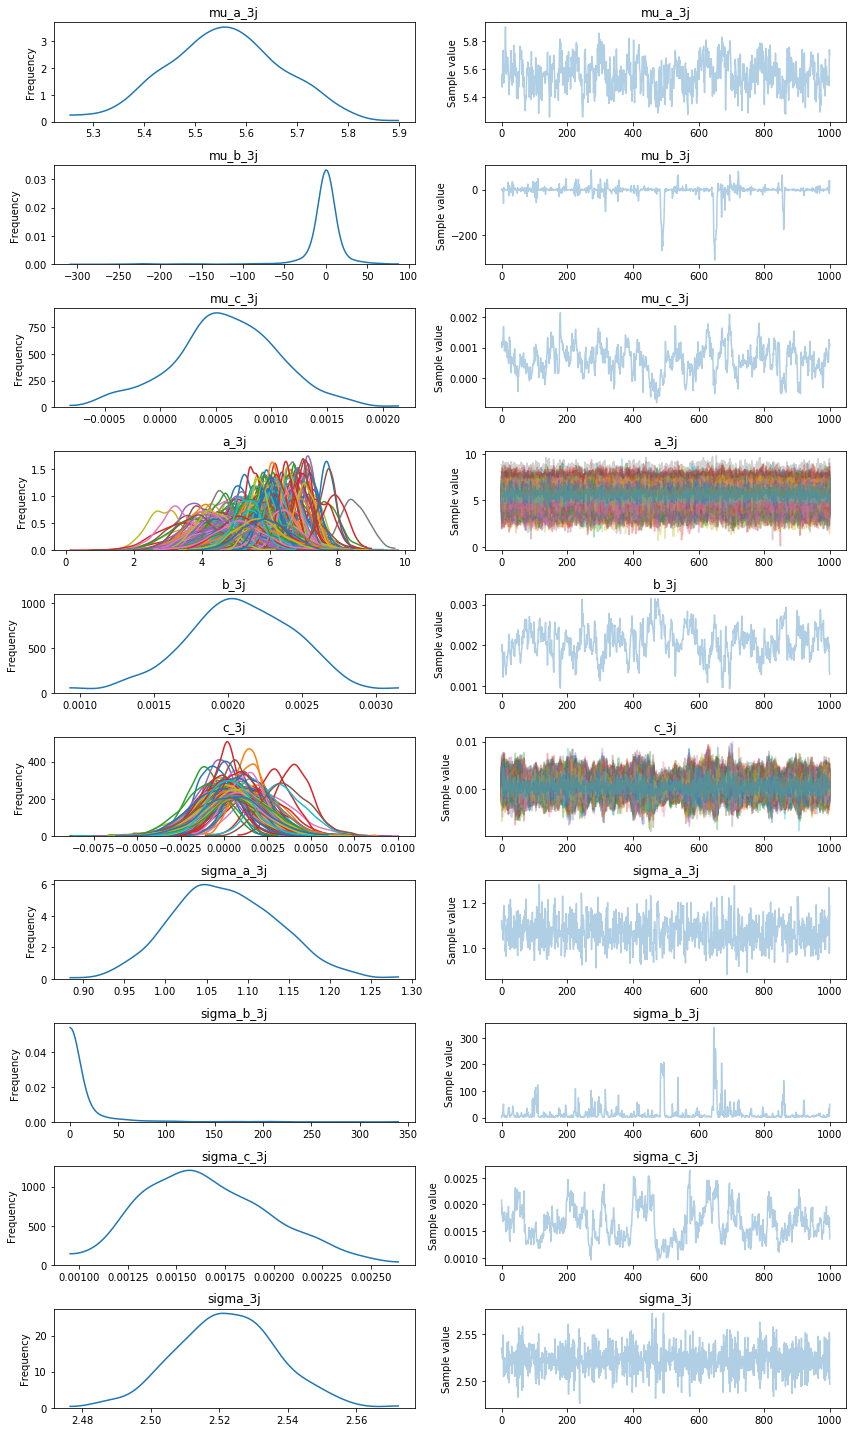

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [01:01<00:00, 24.52it/s]/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 172 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



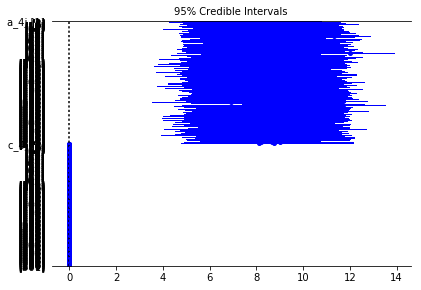

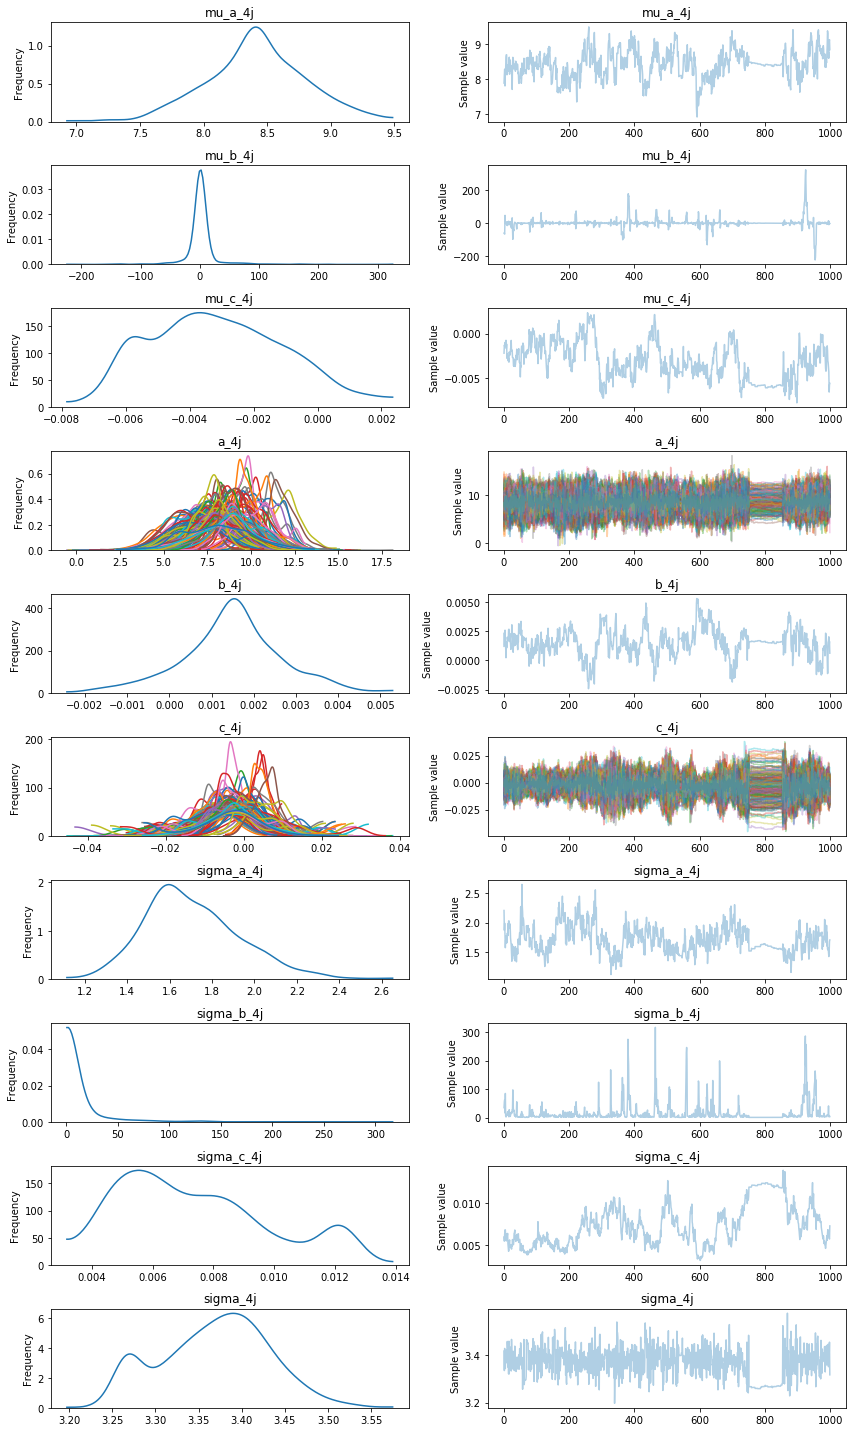

In [42]:
for elt_type, prior_mu, prior_sd in (('sp', 2.5, 0.5), ('ch', 2., 0.5), ('st', 3., 0.5), 
                                     ('1j', 0.67, 0.01), ('2j', 4., 0.5), ('3j', 6., 0.7), ('4j', 10.5, 1.0)):
    elts = elements[elements.elt_type == elt_type]
    
    # Predictors/group indicators.
    skater = elts['skater_code'] = elts.skater.replace(skater_lookup).values
    skater = theano.shared(skater)
    start_overall = np.asarray(elts.weeks_since_overall_start)
    start_overall = theano.shared(start_overall)
    start_skater = np.asarray(elts.weeks_since_skater_start)
    start_skater = theano.shared(start_skater)
    
    points = elts.points
    
    model = pm.Model()
    with model:
        # Prior on group distribution.
        mu_a = pm.Normal('mu_a_' + elt_type, prior_mu, sd=prior_sd)
        sigma_a = pm.HalfCauchy('sigma_a_' + elt_type, 5)
        mu_b = pm.Normal('mu_b_' + elt_type, mu=0., sd=1e5)
        sigma_b = pm.HalfCauchy('sigma_b_' + elt_type, 5)
        mu_c = pm.Normal('mu_c_' + elt_type, mu=0., sd=1e5)
        sigma_c = pm.HalfCauchy('sigma_c_' + elt_type, 5)
        
        # Group distribution.
        a = pm.Normal('a_' + elt_type, mu_a, sd=sigma_a, shape=num_skaters)
        b = pm.Normal('b_' + elt_type, mu_b, sd=sigma_b)
        c = pm.Normal('c_' + elt_type, mu_c, sd=sigma_c, shape=num_skaters)
        sigma = pm.HalfCauchy('sigma_' + elt_type, 5)
        
        y_hat = a[skater] + b * start_overall + c[skater] * start_skater
        
        # Data model.
        y = pm.Normal('y_' + elt_type, y_hat, sd=sigma, observed=points)

    # Fit the model.
    with model:
        trace = pm.sample(draws=1000, tune=500)
        
    # Save the results.
    results[elt_type] = (trace, model, (skater, start_overall, start_skater))
    
    # Visualize fit.
    pm.forestplot(trace, varnames=['a_' + elt_type, 'c_' + elt_type])
    pm.traceplot(trace)
    plt.show()
#     estimates = pd.Series(trace['mu_' + elt_type].mean(axis=0), index=skaters)
#     se = pd.Series(trace['mu_' + elt_type].std(axis=0), index=skaters)
#     order = estimates.sort_values().index
#     plt.scatter(xrange(len(estimates)), estimates[order])
#     for i, m, s in zip(range(len(estimates)), estimates[order], se[order]):
#         plt.plot([i,i], [m-s, m+s], 'b-')
#     plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Skater');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [13:55<00:00,  1.20it/s]


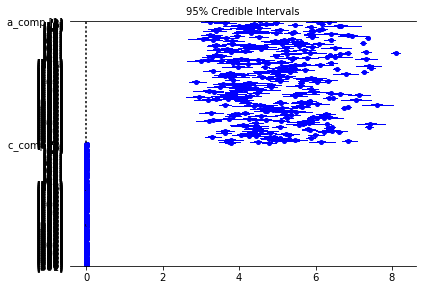

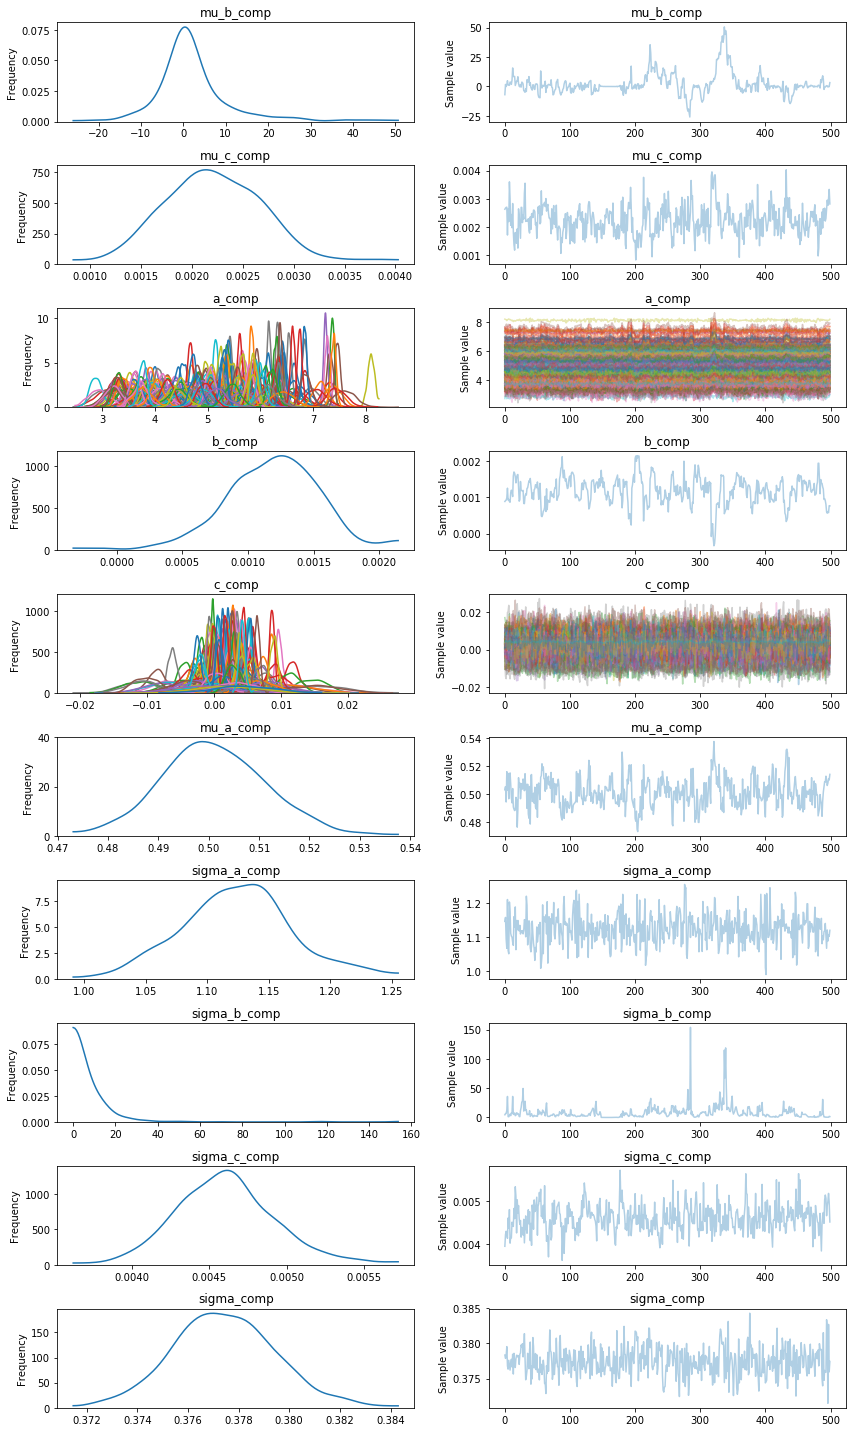

In [65]:
skater = components['skater_code'] = components.skater.replace(skater_lookup).values
skater = theano.shared(skater)
start_overall = np.asarray(components.weeks_since_overall_start)
start_overall = theano.shared(start_overall)
start_skater = np.asarray(components.weeks_since_skater_start)
start_skater = theano.shared(start_skater)

points = components.points

model = pm.Model()
with model:
    # Prior on group distribution.
    mu_a = 10 * pm.Beta('mu_a_comp', alpha=20, beta=6)
    sigma_a = pm.HalfCauchy('sigma_a_comp', 5)
    mu_b = pm.Normal('mu_b_comp', mu=0., sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b_comp', 5)
    mu_c = pm.Normal('mu_c_comp', mu=0., sd=1e5)
    sigma_c = pm.HalfCauchy('sigma_c_comp', 5)

    # Group distribution.
    a = pm.Normal('a_comp', mu_a, sd=sigma_a, shape=num_skaters)
    b = pm.Normal('b_comp', mu_b, sd=sigma_b)
    c = pm.Normal('c_comp', mu_c, sd=sigma_c, shape=num_skaters)
    sigma = pm.HalfCauchy('sigma_comp', 5)

    y_hat = a[skater] + b * start_overall + c[skater] * start_skater

    # Data model.
    y = pm.Normal('y_comp', y_hat, sd=sigma, observed=points)

# Fit the model.
with model:
    trace = pm.sample(samples=1000, tune=500)

# Save the results.
results['component'] = (trace, model, (skater, start_overall, start_skater))

# Visualize fit.
pm.forestplot(trace, varnames=['a_comp', 'c_comp'])
pm.traceplot(trace)
plt.show()

In [45]:
elements18 = pd.read_csv('pd_data/elements18_men.csv')
components18 = pd.read_csv('pd_data/components_summary18_men.csv')
elements18.date = elements18.date.astype('datetime64')
components18.date = components18.date.astype('datetime64')

In [46]:
elements18['skater_code'] = elements18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)
components18['skater_code'] = components18.apply(lambda row: skater_lookup.get(row.skater, -1), axis=1)

In [50]:
# Update skater_start for new data.
for skater in elements18.skater.unique():
    if skater in skater_start:
        continue
    skater_elts = elements18[elements18.skater == skater]
    skater_start[skater] = skater_elts.date.unique()[0]

In [53]:
elements18['weeks_since_skater_start'] = elements18.apply(
    lambda row: row.date - skater_start[row.skater], axis=1
).astype('timedelta64[W]')
components18['weeks_since_skater_start'] = components18.apply(
    lambda row: row.date - skater_start[row.skater], axis=1
).astype('timedelta64[W]')

In [54]:
elements18['weeks_since_overall_start'] = elements18.apply(
    lambda row: row.date - overall_start, axis=1
).astype('timedelta64[W]')
components18['weeks_since_overall_start'] = components18.apply(
    lambda row: row.date - overall_start, axis=1
).astype('timedelta64[W]')

In [55]:
ppc = {}
means = {}

100%|██████████| 500/500 [00:00<00:00, 1308.36it/s]


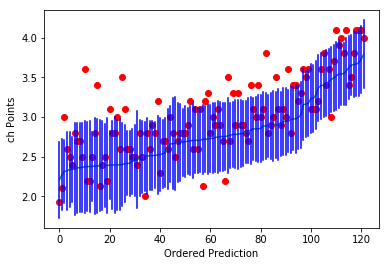

100%|██████████| 500/500 [00:00<00:00, 1434.26it/s]


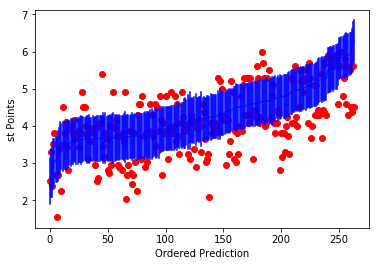

100%|██████████| 500/500 [00:00<00:00, 1297.08it/s]


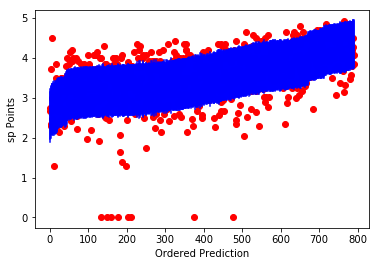

100%|██████████| 500/500 [00:00<00:00, 1686.57it/s]


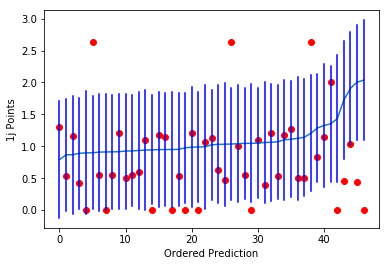

100%|██████████| 500/500 [00:00<00:00, 1541.18it/s]


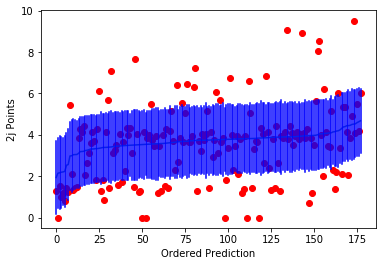

100%|██████████| 500/500 [00:00<00:00, 943.00it/s]


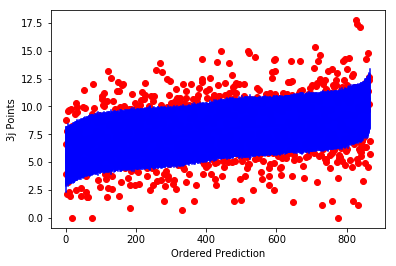

100%|██████████| 500/500 [00:00<00:00, 1414.67it/s]


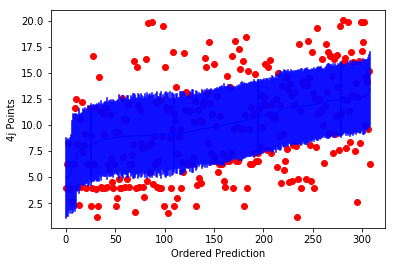

In [56]:
for elt_type in ELT_TYPES:
    elts = elements18[elements18.elt_type == elt_type]
    results[elt_type][2][0].set_value(np.asarray(elts.skater_code))
    results[elt_type][2][1].set_value(np.asarray(elts.weeks_since_overall_start))
    results[elt_type][2][2].set_value(np.asarray(elts.weeks_since_skater_start))
    
    ppc[elt_type] = pm.sample_ppc(trace=results[elt_type][0], model=results[elt_type][1], samples=500)['y_' + elt_type]

    mean = means[elt_type] = ppc[elt_type].mean(axis=0)
    std = np.std(ppc[elt_type], axis=0)
    real_outcomes = elements18[elements18.elt_type == elt_type]
    order = pd.Series(mean).sort_values().index
    outcomes = []
    for index in order:
        outcomes.append(real_outcomes.iloc[index].points)
    plt.scatter(xrange(len(mean)), outcomes, color='r')
    plt.plot(xrange(len(mean)), [mean[x] for x in order])
    for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
        plt.plot([i,i], [m-s, m+s], 'b-')
    plt.ylabel(elt_type + ' Points');plt.xlabel('Ordered Prediction');
    plt.show()

100%|██████████| 500/500 [00:00<00:00, 1406.80it/s]


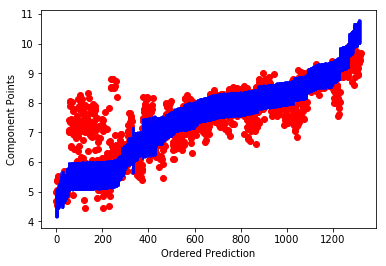

In [66]:
results['component'][2][0].set_value(np.asarray(components18.skater_code))
results['component'][2][1].set_value(np.asarray(components18.weeks_since_overall_start))
results['component'][2][2].set_value(np.asarray(components18.weeks_since_skater_start))

ppc_result = pm.sample_ppc(trace=results['component'][0], model=results['component'][1], samples=500)
ppc['component'] = ppc_result['y_comp']

mean = means['component'] = ppc['component'].mean(axis=0)
std = np.std(ppc['component'], axis=0)

# Sort actual point outcomes by order predicted by model.
real_outcomes = components18
order = pd.Series(mean).sort_values().index
outcomes = []
for index in order:
    outcomes.append(real_outcomes.iloc[index].points)
plt.scatter(xrange(len(mean)), outcomes, color='r')
plt.plot(xrange(len(mean)), [mean[x] for x in order])
for i, m, s in zip(xrange(len(mean)), mean[order], std[order]):
    plt.plot([i,i], [m-s, m+s], 'b-')
plt.ylabel('Component Points');plt.xlabel('Ordered Prediction');
plt.show()

In [81]:
elt_predictions = elements18[['segment', 'event', 'element', 'elt_type', 'points', 'skater', 'skater_code']].copy()
comp_predictions = components18[['comp_type', 'event', 'segment', 'points', 'skater', 'skater_code']].copy()

In [82]:
elt_pred_col = []
elt_indices = {elt_type: 0 for elt_type in ELT_TYPES}
for index, row in elt_predictions.iterrows():
    elt_pred_col.append(means[row.elt_type][elt_indices[row.elt_type]])
    elt_indices[row.elt_type] += 1

In [83]:
elt_predictions['prediction'] = elt_pred_col
comp_predictions['prediction'] = means['component']

In [84]:
comp_predictions.rename(columns={'comp_type': 'elt_type'}, inplace=True)
elt_predictions['is_elt'] = pd.Series([1] * len(elt_pred_col))
comp_predictions['is_elt'] = pd.Series([0] * len(comp_predictions))

In [85]:
predictions = pd.concat([elt_predictions, comp_predictions])
predictions.to_csv('fits/men_predictions3.csv')

In [88]:
comps_history = {}   # comps_history[skater][comp_type] is max historical components score for skater

In [89]:
for skater in components18.skater.unique():
    skater_comps = components[components.skater == skater]
    comps_history[skater] = {}
    for comp_type in COMP_TYPES:
        comps_history[skater][comp_type] = skater_comps[skater_comps.comp_type == comp_type].points.max()

In [90]:
all_pbs = {comp_type: [] for comp_type in COMP_TYPES}
for pb in comps_history.values():
    if pd.isnull(pb['co']):
        continue
    for comp_type in COMP_TYPES:
        all_pbs[comp_type].append(pb[comp_type])

In [91]:
comp_avg = {comp_type: np.median(all_pbs[comp_type]) for comp_type in COMP_TYPES}
for skater, pb in comps_history.iteritems():
    if pd.isnull(pb['co']):
        comps_history[skater] = comp_avg

In [96]:
comp_predictions = components18[['comp_type', 'event', 'segment', 'points', 'skater', 'skater_code']].copy()
comp_pred_col = []
comp_indices = {comp_type: 0 for comp_type in COMP_TYPES}
for index, row in comp_predictions.iterrows():
    comp_pred_col.append(comps_history[row.skater][row.comp_type])
    comp_indices[row.comp_type] += 1
comp_predictions['prediction'] = comp_pred_col

In [97]:
comp_predictions.rename(columns={'comp_type': 'elt_type'}, inplace=True)
elt_predictions['is_elt'] = pd.Series([1] * len(elt_pred_col))
comp_predictions['is_elt'] = pd.Series([0] * len(comp_predictions))

In [101]:
predictions = pd.concat([elt_predictions, comp_predictions])
predictions.to_csv('fits/men_predictions3.5.csv')

In [102]:
predictions2 = pd.read_csv('fits/men_predictions2.csv')

In [104]:
predictions2 = predictions2[predictions2.is_elt == 0]

In [106]:
predictions = pd.concat([elt_predictions, predictions2])
predictions.to_csv('fits/men_predictions3.6.csv')